In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from tqdm.auto import tqdm


In [21]:
data = pd.read_csv("bank_marketing/bank/bank-full.csv", sep = ';')

pd.set_option('future.no_silent_downcasting', True)
data['y']= data['y'].replace({'yes':1, 'no': 0})

In [22]:
# Identify categorical columns in DataFrame

X= data.drop(columns=['y']) # Independent variables
y= data['y'] # target variable
y=y.astype(int)

In [23]:
# Split 60% for training and 40% for val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split 20% for validation and 20% for testing from the remaining 40%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Print shapes of resulting splits to check
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (27126, 16) (27126,)
Validation set size: (9042, 16) (9042,)
Test set size: (9043, 16) (9043,)


In [24]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns

# One-Hot Encode the categorical variables in the training and validation sets

encoder = OneHotEncoder(drop='first', sparse_output=False)  # to avoid multicollinearity

# Fit the encoder on the training data and transform both train and validation sets
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]))
X_val_encoded = pd.DataFrame(encoder.transform(X_val[categorical_cols]))

# Reset index to ensure alignment of rows after one-hot encoding
X_train_encoded.index = X_train.index
X_val_encoded.index = X_val.index

# Drop the original categorical columns and concatenate the one-hot encoded columns
X_train_final = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded], axis=1)
X_val_final = pd.concat([X_val.drop(columns=categorical_cols), X_val_encoded], axis=1)
X_train_final.columns = X_train_final.columns.astype(str)
X_val_final.columns = X_val_final.columns.astype(str)

In [25]:
# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_final, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [26]:
# Question 1: ROC AUC feature importance. Highest feature AUC
# Answer: `duration`

df1 = X_train_final[['balance', 'day', 'duration', 'previous']]

# Loop through each variable
for var in df1:
    # Calculate AUC for the current variable
    auc_score = roc_auc_score(y_train, df1[var])
    print(f"AUC for {var}: {auc_score:.2f}")
    
    # Check if AUC is less than 0.5, meaning a negative correlation
    if auc_score < 0.5:
        print(f"{var} is negatively correlated, negating the values...")
        # Negate the variable to reverse the correlation
        neg_auc_score = roc_auc_score(y_train, -df1[var])
        print(f"AUC for negated {var}: {neg_auc_score:.2f}")

AUC for balance: 0.59
AUC for day: 0.48
day is negatively correlated, negating the values...
AUC for negated day: 0.52
AUC for duration: 0.81
AUC for previous: 0.60


In [27]:
# Question 2. Validation AUC 
# Answer: Approximately 0.9

# Convert DataFrame to dictionary format for DictVectorizer
data_dicts = X.to_dict(orient='records')

# Apply DictVectorizer to one-hot encode categorical variables
vectorizer = DictVectorizer(sparse=False)
X_encoded = vectorizer.fit_transform(data_dicts)

# Split the data into train/val/test sets (60%/20%/20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [28]:
# Make predictions on the validation set
y_val_probs = model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class


# Calculate AUC score
auc_score = roc_auc_score(y_val, y_val_probs)
print(f"AUC Score: {round(auc_score, 3)}")

AUC Score: 0.907


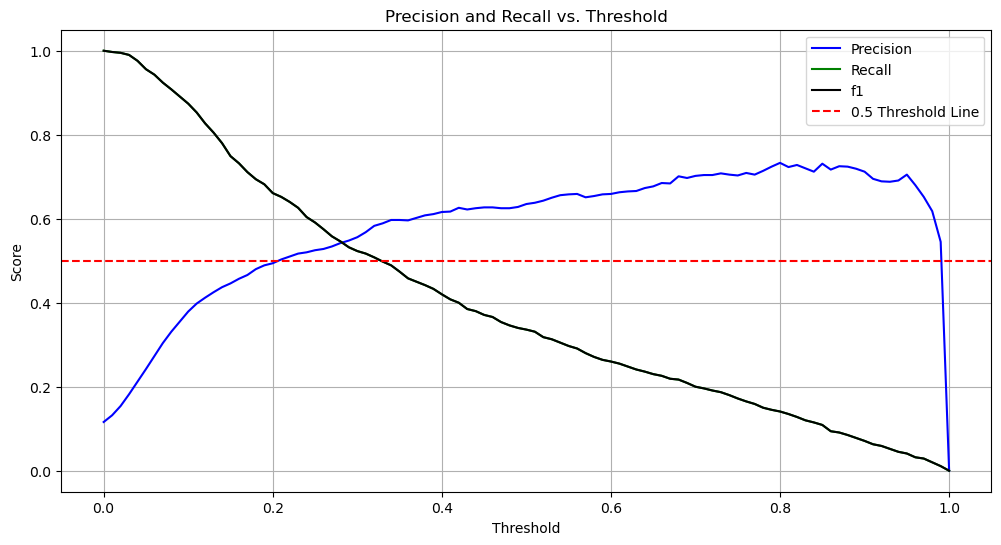

In [29]:
# Question 3. Precision and recall
# Answer: Prediction and recall score intersect at a liitle over 2.5 threshold

# Define thresholds to evaluate precision and recall
thresholds = np.arange(0.0, 1.01, 0.01)  # From 0.0 to 1.0 with a step of 0.01

# Store metrics for each threshold
precision_list = []
recall_list = []
f1_list = []

# Calculate precision, recall, and F1 score for each threshold
for threshold in thresholds:
    y_val_pred = (y_val_probs >= threshold).astype(int)
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)

    #computing F1 using formula
    if precision + recall > 0:
        f1 = 2 * (precision * recall)/ (precision + recall)
    else:
        f1 = 0
    
    # Append metrics to the lists
    precision_list.append(round(precision, 3))
    recall_list.append(round(recall, 3))
    f1_list.append(round(f1, 3))

# Plot Precision and Recall
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision_list, label='Precision', color='blue')
plt.plot(thresholds, recall_list, label='Recall', color='green')
plt.plot(thresholds, recall_list, label='f1', color='black')
plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.axhline(y=0.5, color='r', linestyle='--', label='0.5 Threshold Line')  # Optional threshold line
plt.legend()
plt.grid()
plt.show()

In [30]:
# Question 4: F1 score threshold
# Answer: About 0.2

# Display F1 scores for each threshold
f1_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

f1_max = max(f1_list)
optimal_threshold = thresholds[f1_list.index(f1_max)]
print(f"The maximum F1 score is: {f1_max:.3f} at threshold optimal threshold: {optimal_threshold}")
print(f1_df[['Threshold', 'Precision', 'Recall', 'F1 Score']])

The maximum F1 score is: 0.569 at threshold optimal threshold: 0.19
     Threshold  Precision  Recall  F1 Score
0         0.00      0.116   1.000     0.208
1         0.01      0.132   0.997     0.233
2         0.02      0.154   0.995     0.267
3         0.03      0.182   0.990     0.307
4         0.04      0.212   0.976     0.349
..         ...        ...     ...       ...
96        0.96      0.680   0.032     0.062
97        0.97      0.652   0.029     0.055
98        0.98      0.618   0.020     0.039
99        0.99      0.545   0.011     0.022
100       1.00      0.000   0.000     0.000

[101 rows x 4 columns]


In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
C = 1.0  

# Iterate over the K-Folds
for train_idx, val_idx in tqdm(kfold.split(X_train), total=kfold.get_n_splits()):
    # Split the data into training and validation sets
    df_train = X_train.iloc[train_idx]
    df_val = X_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    # One-hot encode the features using DictVectorizer
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.drop('y', axis=1).to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val.drop('y', axis=1).to_dict(orient='records')
    X_val = dv.transform(val_dict)

    # Train the Logistic Regression model
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict probabilities for validation set
    y_pred = model.predict_proba(X_val)[:, 1]

    # Calculate AUC score for validation set
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

# Output the mean and standard deviation of AUC scores
print(f'C={C} Mean AUC: {np.mean(scores):.3f} +- {np.std(scores):.3f}')


  0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [38]:
# C values to test
C_values = [0.000001, 0.001, 1]

# Initialize KFold with 5 splits
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

best_mean_auc = 0
best_std_auc = float('inf')
best_C = None

# Iterate over each value of C
for C in C_values:
    print(f"Evaluating C={C}")
    
    scores = []

    # kfold splitting
    for train_idx, val_idx in tqdm(kfold.split(X_train_final), total=kfold.get_n_splits()):
        df_train = X_train_final.iloc[train_idx]
        df_val = X_train_final.iloc[val_idx]
        
        # Use the target values from y_train_final
        y_train = y_train[train_idx]
        y_val = y_train[val_idx]

        # One-hot encode the features using DictVectorizer
        dv = DictVectorizer(sparse=False)
        train_dict = df_train.drop('y', axis=1).to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        val_dict = df_val.drop('y', axis=1).to_dict(orient='records')
        X_val = dv.transform(val_dict)

        # Train the Logistic Regression model with the current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Predict probabilities for validation set
        y_pred = model.predict_proba(X_val)[:, 1]

        # Calculate AUC score for validation set
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    # Compute the mean and standard deviation of AUC scores for the current C
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)

    print(f'C={C}: Mean AUC={mean_auc:.3f}, Std AUC={std_auc:.3f}')
    
    # Update the best C based on mean AUC, and then by std_auc in case of ties
    if (mean_auc > best_mean_auc) or (mean_auc == best_mean_auc and std_auc < best_std_auc):
        best_mean_auc = mean_auc
        best_std_auc = std_auc
        best_C = C


# Print the best C value and its corresponding mean and std
print(f'Best C={best_C} with Mean AUC={best_mean_auc:.3f} and Std AUC={best_std_auc:.3f}')

Evaluating C=1e-06


  0%|          | 0/5 [00:00<?, ?it/s]

KeyError: '[1, 4, 6, 7, 17, 30, 43, 49, 52, 53, 61, 63, 70, 71, 75, 80, 83, 86, 89, 90, 92, 96, 98, 99, 101, 103, 104, 109, 116, 120, 121, 122, 128, 133, 137, 139, 140, 142, 144, 147, 150, 158, 165, 167, 172, 173, 176, 180, 182, 186, 194, 198, 200, 204, 210, 212, 214, 216, 217, 222, 223, 226, 233, 241, 243, 248, 250, 251, 261, 262, 263, 264, 266, 267, 268, 269, 270, 272, 273, 274, 277, 278, 279, 280, 283, 286, 289, 297, 298, 304, 309, 311, 312, 313, 314, 317, 323, 326, 334, 341, 342, 344, 345, 346, 348, 351, 353, 355, 359, 373, 374, 376, 377, 378, 379, 380, 382, 385, 388, 396, 399, 401, 403, 408, 409, 411, 416, 418, 423, 429, 430, 431, 436, 437, 441, 447, 451, 452, 459, 460, 462, 464, 465, 469, 471, 474, 475, 478, 479, 480, 483, 485, 494, 498, 499, 505, 509, 513, 516, 517, 521, 523, 532, 536, 537, 539, 542, 549, 550, 564, 566, 572, 573, 575, 576, 578, 579, 581, 584, 586, 588, 593, 603, 607, 609, 616, 621, 622, 623, 624, 626, 628, 629, 630, 631, 640, 644, 646, 647, 648, 649, 651, 655, 657, 664, 672, 673, 674, 677, 681, 682, 697, 702, 705, 708, 710, 712, 718, 724, 725, 729, 734, 736, 738, 740, 741, 742, 745, 747, 748, 754, 756, 758, 762, 764, 768, 772, 773, 775, 776, 779, 780, 791, 795, 802, 816, 819, 821, 831, 833, 839, 841, 842, 843, 844, 850, 852, 853, 857, 861, 871, 873, 879, 880, 883, 890, 892, 894, 895, 896, 898, 900, 902, 904, 912, 913, 919, 926, 927, 928, 930, 936, 939, 940, 942, 943, 949, 951, 952, 953, 957, 960, 963, 967, 971, 979, 980, 983, 985, 990, 991, 995, 996, 1000, 1003, 1006, 1008, 1009, 1012, 1029, 1030, 1032, 1034, 1039, 1042, 1043, 1048, 1053, 1056, 1057, 1060, 1061, 1065, 1066, 1068, 1072, 1077, 1078, 1086, 1087, 1092, 1097, 1100, 1103, 1106, 1107, 1108, 1109, 1111, 1114, 1118, 1121, 1122, 1126, 1131, 1133, 1138, 1139, 1142, 1143, 1146, 1147, 1148, 1149, 1152, 1157, 1162, 1163, 1164, 1165, 1166, 1173, 1175, 1179, 1180, 1182, 1183, 1188, 1189, 1190, 1192, 1194, 1197, 1204, 1213, 1215, 1219, 1220, 1221, 1226, 1227, 1229, 1232, 1240, 1243, 1248, 1253, 1259, 1261, 1271, 1274, 1275, 1277, 1278, 1280, 1285, 1288, 1296, 1298, 1309, 1311, 1317, 1318, 1319, 1321, 1323, 1328, 1330, 1331, 1334, 1337, 1344, 1346, 1347, 1348, 1350, 1351, 1357, 1370, 1380, 1387, 1388, 1390, 1395, 1396, 1397, 1399, 1400, 1402, 1406, 1410, 1411, 1412, 1413, 1416, 1417, 1418, 1422, 1423, 1426, 1429, 1430, 1433, 1434, 1441, 1442, 1444, 1446, 1448, 1450, 1451, 1453, 1456, 1457, 1459, 1464, 1465, 1470, 1471, 1474, 1478, 1483, 1484, 1487, 1489, 1490, 1491, 1494, 1496, 1497, 1498, 1500, 1503, 1507, 1508, 1512, 1514, 1516, 1521, 1523, 1527, 1534, 1540, 1549, 1550, 1553, 1554, 1555, 1557, 1558, 1562, 1563, 1564, 1565, 1568, 1570, 1572, 1576, 1583, 1584, 1588, 1590, 1594, 1608, 1610, 1612, 1615, 1616, 1623, 1631, 1632, 1635, 1640, 1644, 1647, 1650, 1655, 1656, 1660, 1661, 1668, 1670, 1671, 1672, 1673, 1675, 1676, 1677, 1680, 1681, 1682, 1687, 1691, 1696, 1697, 1699, 1707, 1710, 1712, 1715, 1717, 1719, 1721, 1729, 1730, 1731, 1736, 1738, 1741, 1748, 1763, 1784, 1786, 1788, 1791, 1793, 1794, 1796, 1800, 1801, 1805, 1807, 1808, 1812, 1815, 1817, 1818, 1819, 1826, 1829, 1830, 1836, 1837, 1838, 1839, 1844, 1846, 1850, 1851, 1856, 1859, 1864, 1866, 1871, 1873, 1876, 1878, 1884, 1886, 1888, 1889, 1890, 1895, 1900, 1904, 1905, 1911, 1912, 1923, 1930, 1931, 1937, 1944, 1956, 1972, 1974, 1975, 1977, 1981, 1985, 1991, 1992, 1993, 1994, 1997, 2001, 2004, 2007, 2008, 2009, 2018, 2020, 2022, 2029, 2033, 2034, 2041, 2043, 2053, 2054, 2059, 2070, 2071, 2075, 2081, 2084, 2087, 2088, 2090, 2091, 2094, 2095, 2104, 2109, 2110, 2111, 2115, 2116, 2117, 2119, 2126, 2127, 2129, 2133, 2136, 2138, 2140, 2142, 2145, 2146, 2149, 2150, 2153, 2158, 2165, 2166, 2168, 2174, 2180, 2181, 2182, 2185, 2186, 2189, 2190, 2191, 2194, 2195, 2201, 2207, 2208, 2210, 2211, 2213, 2215, 2222, 2227, 2229, 2231, 2236, 2237, 2239, 2240, 2242, 2245, 2247, 2252, 2254, 2255, 2256, 2258, 2259, 2264, 2269, 2276, 2279, 2280, 2281, 2284, 2286, 2287, 2290, 2292, 2294, 2295, 2296, 2298, 2299, 2300, 2304, 2305, 2306, 2308, 2310, 2312, 2318, 2319, 2320, 2322, 2323, 2325, 2331, 2333, 2337, 2338, 2341, 2342, 2343, 2344, 2346, 2350, 2351, 2357, 2361, 2362, 2363, 2372, 2373, 2374, 2375, 2383, 2386, 2388, 2390, 2393, 2397, 2398, 2399, 2405, 2406, 2408, 2411, 2414, 2417, 2435, 2436, 2437, 2440, 2441, 2445, 2448, 2449, 2453, 2456, 2457, 2464, 2467, 2471, 2489, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2501, 2510, 2514, 2515, 2517, 2527, 2531, 2533, 2538, 2544, 2545, 2546, 2547, 2549, 2558, 2561, 2564, 2571, 2572, 2577, 2579, 2582, 2584, 2585, 2588, 2592, 2593, 2595, 2601, 2602, 2604, 2605, 2608, 2616, 2619, 2622, 2624, 2625, 2626, 2627, 2633, 2638, 2639, 2644, 2645, 2649, 2650, 2653, 2658, 2662, 2664, 2672, 2676, 2677, 2678, 2679, 2680, 2683, 2691, 2692, 2705, 2707, 2709, 2710, 2714, 2715, 2718, 2724, 2725, 2729, 2730, 2731, 2735, 2740, 2743, 2744, 2746, 2750, 2754, 2756, 2758, 2760, 2762, 2764, 2767, 2772, 2789, 2791, 2796, 2799, 2805, 2813, 2814, 2817, 2825, 2826, 2828, 2834, 2842, 2845, 2847, 2848, 2854, 2855, 2856, 2857, 2858, 2863, 2864, 2865, 2867, 2873, 2874, 2875, 2876, 2883, 2884, 2885, 2896, 2898, 2899, 2900, 2901, 2902, 2903, 2916, 2917, 2923, 2924, 2927, 2929, 2931, 2942, 2947, 2948, 2949, 2950, 2954, 2955, 2965, 2967, 2969, 2973, 2974, 2982, 2984, 2987, 2989, 2992, 2993, 3000, 3001, 3002, 3003, 3007, 3012, 3013, 3014, 3021, 3023, 3025, 3027, 3028, 3029, 3030, 3031, 3033, 3036, 3038, 3043, 3047, 3049, 3050, 3053, 3056, 3063, 3067, 3068, 3074, 3077, 3082, 3096, 3103, 3104, 3105, 3106, 3108, 3109, 3110, 3113, 3115, 3116, 3120, 3122, 3124, 3125, 3132, 3141, 3150, 3154, 3155, 3160, 3163, 3165, 3168, 3176, 3177, 3179, 3180, 3183, 3184, 3186, 3189, 3193, 3197, 3198, 3200, 3208, 3210, 3211, 3219, 3220, 3222, 3226, 3229, 3234, 3241, 3242, 3243, 3245, 3246, 3248, 3250, 3252, 3254, 3256, 3263, 3264, 3265, 3266, 3269, 3270, 3272, 3277, 3279, 3281, 3282, 3287, 3288, 3290, 3296, 3303, 3305, 3308, 3309, 3313, 3316, 3318, 3341, 3344, 3349, 3350, 3353, 3356, 3357, 3362, 3366, 3367, 3375, 3377, 3378, 3379, 3382, 3383, 3386, 3387, 3388, 3391, 3396, 3398, 3401, 3402, 3406, 3410, 3416, 3417, 3418, 3419, 3425, 3426, 3427, 3428, 3431, 3434, 3438, 3441, 3442, 3444, 3445, 3448, 3451, 3452, 3459, 3460, 3461, 3469, 3470, 3478, 3480, 3481, 3482, 3483, 3488, 3489, 3493, 3494, 3495, 3500, 3502, 3503, 3504, 3507, 3508, 3511, 3517, 3524, 3525, 3528, 3529, 3530, 3539, 3541, 3542, 3547, 3548, 3555, 3559, 3560, 3566, 3570, 3578, 3580, 3581, 3584, 3585, 3589, 3592, 3593, 3594, 3601, 3605, 3609, 3611, 3614, 3615, 3617, 3618, 3619, 3622, 3633, 3634, 3635, 3637, 3638, 3643, 3645, 3653, 3662, 3673, 3678, 3687, 3690, 3693, 3698, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3710, 3714, 3715, 3725, 3732, 3734, 3735, 3737, 3740, 3751, 3752, 3753, 3758, 3761, 3772, 3776, 3777, 3778, 3779, 3781, 3787, 3789, 3790, 3792, 3798, 3799, 3803, 3804, 3808, 3813, 3818, 3820, 3826, 3829, 3831, 3834, 3835, 3836, 3839, 3840, 3842, 3843, 3848, 3850, 3852, 3853, 3855, 3861, 3863, 3874, 3876, 3885, 3886, 3891, 3893, 3897, 3901, 3905, 3910, 3915, 3916, 3918, 3921, 3923, 3928, 3929, 3931, 3935, 3938, 3939, 3940, 3941, 3942, 3944, 3945, 3949, 3953, 3954, 3955, 3964, 3973, 3979, 3984, 3986, 3988, 3989, 3997, 3998, 4002, 4003, 4004, 4009, 4010, 4012, 4020, 4021, 4028, 4029, 4032, 4034, 4040, 4045, 4047, 4048, 4051, 4056, 4057, 4058, 4060, 4061, 4062, 4064, 4070, 4071, 4072, 4077, 4080, 4082, 4084, 4085, 4086, 4091, 4092, 4093, 4095, 4097, 4101, 4104, 4106, 4107, 4108, 4109, 4119, 4121, 4128, 4130, 4140, 4144, 4146, 4148, 4149, 4152, 4155, 4156, 4157, 4159, 4161, 4162, 4164, 4165, 4168, 4169, 4178, 4180, 4181, 4183, 4189, 4191, 4193, 4194, 4196, 4199, 4200, 4201, 4202, 4209, 4212, 4214, 4215, 4216, 4217, 4219, 4220, 4222, 4227, 4229, 4230, 4233, 4235, 4237, 4241, 4243, 4246, 4252, 4254, 4256, 4258, 4262, 4264, 4265, 4266, 4269, 4272, 4277, 4280, 4282, 4283, 4285, 4287, 4289, 4291, 4292, 4293, 4303, 4304, 4305, 4306, 4308, 4320, 4326, 4335, 4336, 4337, 4339, 4342, 4346, 4347, 4348, 4350, 4351, 4361, 4372, 4375, 4376, 4377, 4384, 4387, 4393, 4396, 4399, 4400, 4401, 4402, 4404, 4406, 4408, 4410, 4413, 4416, 4418, 4419, 4420, 4422, 4428, 4430, 4439, 4440, 4443, 4444, 4445, 4448, 4449, 4450, 4455, 4457, 4459, 4463, 4467, 4468, 4472, 4475, 4480, 4483, 4497, 4498, 4500, 4503, 4504, 4505, 4508, 4513, 4518, 4519, 4520, 4523, 4524, 4525, 4526, 4528, 4530, 4538, 4540, 4543, 4545, 4546, 4548, 4550, 4559, 4562, 4564, 4565, 4569, 4571, 4573, 4579, 4589, 4590, 4592, 4593, 4605, 4608, 4612, 4613, 4614, 4619, 4625, 4628, 4630, 4634, 4636, 4638, 4639, 4640, 4644, 4647, 4650, 4653, 4657, 4659, 4660, 4667, 4669, 4672, 4673, 4678, 4680, 4689, 4699, 4705, 4709, 4713, 4716, 4717, 4718, 4724, 4728, 4729, 4730, 4737, 4738, 4740, 4741, 4745, 4749, 4750, 4751, 4755, 4756, 4759, 4762, 4764, 4772, 4775, 4778, 4783, 4785, 4788, 4794, 4800, 4801, 4802, 4805, 4810, 4811, 4812, 4813, 4815, 4817, 4822, 4825, 4831, 4832, 4842, 4847, 4851, 4855, 4859, 4865, 4867, 4869, 4877, 4879, 4880, 4884, 4890, 4892, 4900, 4903, 4911, 4915, 4916, 4918, 4919, 4929, 4932, 4936, 4937, 4943, 4945, 4949, 4952, 4953, 4955, 4957, 4962, 4969, 4972, 4974, 4976, 4977, 4981, 4982, 4985, 4989, 4990, 4995, 4998, 5001, 5003, 5005, 5006, 5010, 5011, 5014, 5016, 5018, 5020, 5026, 5030, 5031, 5035, 5038, 5042, 5047, 5048, 5055, 5066, 5068, 5070, 5076, 5078, 5080, 5081, 5089, 5092, 5098, 5100, 5102, 5107, 5115, 5117, 5121, 5124, 5128, 5133, 5137, 5138, 5139, 5140, 5144, 5148, 5155, 5157, 5158, 5159, 5162, 5165, 5168, 5170, 5173, 5174, 5175, 5179, 5182, 5183, 5187, 5189, 5191, 5195, 5201, 5205, 5211, 5215, 5216, 5219, 5220, 5222, 5223, 5224, 5225, 5227, 5231, 5233, 5236, 5245, 5253, 5259, 5260, 5261, 5264, 5265, 5266, 5270, 5273, 5275, 5278, 5282, 5286, 5288, 5291, 5292, 5298, 5300, 5306, 5317, 5321, 5323, 5325, 5326, 5327, 5329, 5330, 5331, 5332, 5337, 5341, 5346, 5348, 5352, 5354, 5356, 5357, 5358, 5360, 5370, 5371, 5373, 5377, 5379, 5384, 5386, 5388, 5390, 5394, 5396, 5401, 5407, 5414, 5420, 5425, 5426, 5427, 5434, 5457, 5460, 5464, 5466, 5467, 5471, 5476, 5477, 5478, 5484, 5485, 5488, 5489, 5490, 5491, 5501, 5504, 5508, 5510, 5511, 5514, 5517, 5523, 5527, 5528, 5532, 5533, 5535, 5536, 5540, 5545, 5548, 5550, 5551, 5553, 5554, 5556, 5557, 5559, 5561, 5563, 5564, 5568, 5570, 5572, 5575, 5579, 5582, 5584, 5588, 5595, 5598, 5599, 5601, 5610, 5613, 5625, 5627, 5628, 5633, 5634, 5638, 5640, 5641, 5643, 5645, 5646, 5652, 5654, 5657, 5658, 5659, 5661, 5662, 5665, 5667, 5671, 5672, 5673, 5676, 5677, 5679, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5692, 5705, 5706, 5707, 5711, 5712, 5715, 5716, 5718, 5726, 5729, 5732, 5733, 5735, 5740, 5742, 5747, 5749, 5756, 5757, 5762, 5763, 5764, 5766, 5770, 5775, 5777, 5780, 5784, 5786, 5787, 5794, 5799, 5803, 5807, 5809, 5810, 5814, 5821, 5822, 5823, 5826, 5836, 5838, 5841, 5843, 5844, 5847, 5853, 5854, 5857, 5859, 5862, 5863, 5864, 5865, 5872, 5874, 5875, 5876, 5878, 5881, 5882, 5883, 5890, 5893, 5897, 5907, 5908, 5911, 5915, 5920, 5923, 5925, 5929, 5934, 5935, 5936, 5940, 5944, 5953, 5954, 5959, 5961, 5963, 5971, 5975, 5976, 5980, 5981, 5986, 5987, 5989, 5991, 5994, 6002, 6003, 6010, 6013, 6014, 6016, 6018, 6020, 6024, 6025, 6029, 6034, 6042, 6043, 6045, 6046, 6048, 6049, 6052, 6056, 6058, 6062, 6065, 6067, 6070, 6072, 6081, 6082, 6087, 6095, 6098, 6100, 6101, 6108, 6110, 6111, 6112, 6117, 6118, 6119, 6126, 6127, 6128, 6129, 6132, 6133, 6134, 6137, 6138, 6140, 6146, 6147, 6148, 6149, 6164, 6165, 6166, 6169, 6176, 6178, 6179, 6181, 6184, 6186, 6187, 6188, 6193, 6195, 6196, 6198, 6199, 6201, 6202, 6204, 6211, 6216, 6217, 6219, 6222, 6223, 6224, 6225, 6230, 6231, 6232, 6233, 6234, 6237, 6239, 6241, 6244, 6245, 6247, 6248, 6249, 6252, 6253, 6258, 6263, 6264, 6267, 6268, 6271, 6272, 6275, 6278, 6281, 6285, 6289, 6292, 6293, 6300, 6308, 6311, 6312, 6314, 6315, 6316, 6319, 6322, 6324, 6326, 6328, 6330, 6332, 6334, 6339, 6340, 6341, 6342, 6343, 6346, 6350, 6352, 6355, 6361, 6363, 6365, 6366, 6367, 6373, 6379, 6381, 6384, 6388, 6390, 6392, 6394, 6395, 6400, 6401, 6404, 6407, 6415, 6418, 6419, 6422, 6424, 6425, 6427, 6428, 6429, 6431, 6432, 6433, 6434, 6436, 6442, 6455, 6456, 6459, 6460, 6462, 6463, 6465, 6468, 6478, 6480, 6481, 6483, 6484, 6489, 6492, 6493, 6494, 6496, 6502, 6504, 6514, 6515, 6521, 6522, 6524, 6526, 6527, 6528, 6535, 6542, 6550, 6551, 6552, 6555, 6556, 6561, 6564, 6567, 6573, 6576, 6578, 6580, 6583, 6585, 6592, 6593, 6594, 6596, 6597, 6601, 6605, 6616, 6623, 6626, 6627, 6633, 6648, 6649, 6650, 6656, 6657, 6658, 6660, 6662, 6663, 6666, 6670, 6671, 6675, 6676, 6679, 6684, 6686, 6689, 6690, 6694, 6698, 6699, 6703, 6705, 6707, 6708, 6712, 6713, 6715, 6720, 6725, 6726, 6730, 6735, 6736, 6739, 6742, 6744, 6747, 6748, 6750, 6752, 6753, 6754, 6756, 6758, 6759, 6769, 6770, 6777, 6778, 6779, 6802, 6803, 6804, 6807, 6809, 6810, 6812, 6813, 6814, 6832, 6839, 6848, 6860, 6863, 6867, 6870, 6871, 6872, 6875, 6879, 6882, 6883, 6887, 6889, 6898, 6899, 6902, 6904, 6906, 6909, 6911, 6915, 6916, 6920, 6925, 6933, 6935, 6936, 6939, 6942, 6943, 6946, 6948, 6951, 6956, 6965, 6969, 6974, 6976, 6977, 6978, 6981, 6983, 6985, 6991, 6992, 6994, 6996, 7001, 7002, 7003, 7007, 7010, 7011, 7020, 7022, 7024, 7027, 7028, 7029, 7030, 7033, 7040, 7047, 7050, 7055, 7060, 7062, 7063, 7064, 7070, 7074, 7075, 7078, 7080, 7090, 7091, 7094, 7096, 7100, 7103, 7104, 7107, 7109, 7112, 7117, 7118, 7119, 7122, 7123, 7126, 7128, 7132, 7133, 7136, 7142, 7144, 7149, 7152, 7155, 7161, 7164, 7165, 7171, 7173, 7174, 7175, 7178, 7180, 7183, 7185, 7186, 7191, 7193, 7195, 7196, 7199, 7204, 7205, 7209, 7212, 7217, 7220, 7221, 7223, 7225, 7229, 7231, 7236, 7237, 7238, 7241, 7247, 7249, 7250, 7258, 7262, 7264, 7266, 7267, 7270, 7272, 7277, 7278, 7281, 7284, 7289, 7293, 7294, 7298, 7301, 7302, 7303, 7305, 7306, 7308, 7309, 7315, 7317, 7320, 7321, 7323, 7325, 7327, 7328, 7330, 7335, 7336, 7337, 7339, 7340, 7341, 7346, 7355, 7356, 7360, 7369, 7375, 7380, 7387, 7388, 7390, 7395, 7401, 7402, 7403, 7406, 7411, 7412, 7416, 7419, 7420, 7422, 7427, 7431, 7439, 7441, 7448, 7451, 7456, 7462, 7468, 7469, 7474, 7475, 7478, 7481, 7495, 7497, 7499, 7503, 7510, 7514, 7515, 7516, 7519, 7525, 7528, 7530, 7534, 7537, 7538, 7539, 7544, 7545, 7553, 7555, 7557, 7563, 7565, 7567, 7570, 7573, 7574, 7576, 7577, 7578, 7579, 7580, 7581, 7586, 7589, 7592, 7594, 7600, 7602, 7603, 7605, 7613, 7620, 7623, 7624, 7625, 7628, 7635, 7638, 7646, 7647, 7650, 7653, 7656, 7665, 7668, 7671, 7672, 7678, 7679, 7680, 7682, 7685, 7686, 7688, 7696, 7698, 7700, 7701, 7705, 7706, 7707, 7708, 7713, 7714, 7718, 7721, 7722, 7723, 7724, 7729, 7730, 7732, 7738, 7742, 7743, 7745, 7751, 7752, 7753, 7755, 7757, 7759, 7760, 7762, 7769, 7776, 7778, 7779, 7780, 7781, 7785, 7786, 7787, 7791, 7792, 7793, 7794, 7800, 7801, 7809, 7811, 7817, 7819, 7821, 7823, 7828, 7831, 7834, 7836, 7840, 7841, 7844, 7845, 7849, 7850, 7852, 7859, 7861, 7863, 7864, 7870, 7871, 7872, 7875, 7876, 7879, 7880, 7881, 7889, 7891, 7893, 7900, 7901, 7905, 7908, 7911, 7912, 7913, 7915, 7917, 7921, 7924, 7934, 7936, 7937, 7940, 7945, 7948, 7950, 7954, 7956, 7963, 7964, 7974, 7976, 7978, 7980, 7981, 7982, 7984, 7986, 7993, 8006, 8008, 8013, 8014, 8019, 8020, 8021, 8022, 8023, 8025, 8028, 8033, 8034, 8038, 8040, 8042, 8045, 8049, 8051, 8054, 8059, 8082, 8085, 8087, 8090, 8091, 8094, 8096, 8101, 8105, 8106, 8111, 8113, 8114, 8119, 8122, 8124, 8132, 8133, 8135, 8139, 8140, 8141, 8145, 8147, 8151, 8153, 8156, 8165, 8166, 8170, 8171, 8175, 8178, 8180, 8184, 8186, 8188, 8190, 8191, 8193, 8200, 8206, 8215, 8217, 8223, 8225, 8227, 8228, 8231, 8233, 8237, 8238, 8240, 8246, 8247, 8248, 8249, 8256, 8270, 8276, 8278, 8279, 8282, 8283, 8285, 8288, 8290, 8292, 8293, 8297, 8310, 8312, 8313, 8317, 8318, 8321, 8322, 8324, 8326, 8331, 8332, 8337, 8339, 8340, 8343, 8344, 8354, 8355, 8356, 8358, 8362, 8363, 8368, 8371, 8372, 8375, 8377, 8379, 8383, 8388, 8394, 8398, 8403, 8404, 8406, 8407, 8408, 8410, 8413, 8416, 8420, 8421, 8422, 8425, 8426, 8432, 8435, 8442, 8445, 8450, 8451, 8453, 8454, 8459, 8466, 8470, 8471, 8473, 8474, 8475, 8476, 8477, 8478, 8480, 8483, 8489, 8492, 8494, 8497, 8499, 8505, 8508, 8510, 8511, 8514, 8517, 8518, 8525, 8532, 8537, 8538, 8541, 8542, 8543, 8546, 8552, 8557, 8561, 8564, 8565, 8568, 8569, 8570, 8574, 8575, 8579, 8582, 8586, 8589, 8590, 8591, 8592, 8596, 8600, 8602, 8604, 8608, 8610, 8613, 8615, 8617, 8622, 8639, 8647, 8648, 8651, 8658, 8659, 8663, 8667, 8668, 8670, 8671, 8672, 8677, 8686, 8687, 8688, 8707, 8710, 8713, 8721, 8726, 8729, 8731, 8737, 8739, 8742, 8745, 8751, 8757, 8761, 8765, 8768, 8771, 8780, 8781, 8784, 8795, 8801, 8807, 8814, 8821, 8824, 8829, 8832, 8841, 8842, 8844, 8845, 8853, 8857, 8858, 8860, 8866, 8868, 8869, 8870, 8871, 8873, 8875, 8877, 8880, 8886, 8889, 8891, 8892, 8893, 8895, 8897, 8898, 8899, 8901, 8903, 8908, 8909, 8910, 8913, 8918, 8919, 8920, 8923, 8925, 8929, 8932, 8934, 8939, 8943, 8944, 8952, 8957, 8960, 8961, 8966, 8970, 8971, 8975, 8976, 8978, 8980, 8982, 8986, 8987, 8993, 9000, 9003, 9006, 9008, 9009, 9010, 9011, 9016, 9020, 9021, 9022, 9023, 9024, 9025, 9026, 9027, 9035, 9036, 9037, 9038, 9040, 9042, 9044, 9048, 9049, 9051, 9052, 9055, 9056, 9057, 9058, 9060, 9061, 9062, 9064, 9072, 9073, 9075, 9084, 9085, 9086, 9087, 9089, 9090, 9097, 9098, 9100, 9103, 9105, 9109, 9113, 9116, 9118, 9124, 9125, 9128, 9129, 9132, 9134, 9137, 9141, 9146, 9149, 9150, 9152, 9153, 9154, 9159, 9162, 9163, 9164, 9165, 9167, 9169, 9170, 9172, 9183, 9186, 9188, 9189, 9192, 9193, 9194, 9195, 9198, 9199, 9205, 9206, 9207, 9220, 9222, 9225, 9232, 9233, 9235, 9238, 9240, 9242, 9246, 9248, 9253, 9254, 9263, 9266, 9270, 9273, 9279, 9281, 9282, 9284, 9285, 9287, 9291, 9293, 9294, 9295, 9296, 9298, 9299, 9301, 9302, 9303, 9307, 9311, 9312, 9317, 9320, 9324, 9328, 9333, 9334, 9339, 9349, 9350, 9351, 9353, 9354, 9362, 9363, 9365, 9366, 9377, 9378, 9381, 9383, 9384, 9389, 9390, 9391, 9392, 9397, 9398, 9400, 9401, 9403, 9405, 9413, 9414, 9420, 9423, 9426, 9433, 9440, 9441, 9444, 9447, 9448, 9451, 9452, 9459, 9469, 9473, 9477, 9478, 9489, 9498, 9499, 9501, 9512, 9513, 9517, 9520, 9523, 9525, 9527, 9531, 9532, 9535, 9538, 9539, 9545, 9547, 9548, 9549, 9550, 9553, 9555, 9556, 9559, 9561, 9562, 9564, 9565, 9571, 9573, 9576, 9577, 9579, 9584, 9590, 9591, 9592, 9595, 9598, 9606, 9618, 9619, 9620, 9621, 9633, 9640, 9641, 9642, 9647, 9648, 9653, 9654, 9658, 9660, 9661, 9672, 9674, 9681, 9682, 9683, 9685, 9687, 9693, 9694, 9697, 9698, 9701, 9702, 9703, 9707, 9708, 9712, 9722, 9723, 9724, 9731, 9733, 9736, 9739, 9743, 9744, 9750, 9753, 9758, 9761, 9766, 9767, 9769, 9771, 9774, 9779, 9781, 9786, 9787, 9790, 9792, 9793, 9798, 9801, 9802, 9803, 9804, 9807, 9810, 9827, 9829, 9830, 9831, 9836, 9838, 9839, 9841, 9842, 9844, 9845, 9846, 9851, 9855, 9856, 9858, 9870, 9875, 9880, 9887, 9889, 9897, 9898, 9899, 9900, 9902, 9905, 9908, 9911, 9918, 9919, 9920, 9925, 9928, 9929, 9931, 9932, 9935, 9936, 9937, 9948, 9951, 9954, 9961, 9975, 9976, 9981, 9985, 9986, 9987, 9992, 9995, 9997, 10008, 10009, 10012, 10013, 10016, 10017, 10020, 10026, 10030, 10036, 10039, 10042, 10043, 10045, 10048, 10050, 10059, 10061, 10062, 10063, 10065, 10071, 10072, 10074, 10075, 10079, 10080, 10081, 10088, 10089, 10091, 10092, 10097, 10098, 10111, 10115, 10123, 10125, 10126, 10127, 10132, 10135, 10137, 10146, 10151, 10160, 10163, 10166, 10172, 10173, 10174, 10175, 10189, 10198, 10201, 10202, 10210, 10214, 10217, 10221, 10226, 10229, 10231, 10237, 10241, 10243, 10245, 10259, 10260, 10261, 10263, 10268, 10276, 10279, 10281, 10284, 10286, 10287, 10290, 10299, 10308, 10311, 10312, 10314, 10323, 10324, 10331, 10333, 10334, 10337, 10339, 10342, 10343, 10347, 10354, 10359, 10365, 10368, 10369, 10371, 10379, 10381, 10383, 10385, 10388, 10389, 10390, 10393, 10397, 10398, 10405, 10406, 10414, 10421, 10422, 10423, 10424, 10425, 10427, 10428, 10430, 10436, 10444, 10445, 10448, 10452, 10453, 10455, 10460, 10463, 10465, 10470, 10474, 10475, 10480, 10484, 10490, 10491, 10493, 10497, 10499, 10500, 10501, 10504, 10506, 10508, 10509, 10513, 10517, 10527, 10530, 10533, 10535, 10536, 10538, 10539, 10542, 10545, 10552, 10557, 10560, 10565, 10571, 10575, 10577, 10580, 10581, 10583, 10586, 10587, 10591, 10592, 10593, 10595, 10598, 10601, 10603, 10604, 10609, 10610, 10612, 10628, 10630, 10632, 10636, 10639, 10642, 10644, 10646, 10648, 10649, 10650, 10656, 10657, 10665, 10669, 10671, 10675, 10676, 10688, 10689, 10695, 10697, 10700, 10713, 10714, 10716, 10718, 10721, 10726, 10727, 10732, 10734, 10735, 10741, 10742, 10743, 10746, 10752, 10764, 10765, 10771, 10772, 10779, 10780, 10783, 10788, 10791, 10795, 10797, 10798, 10802, 10803, 10809, 10820, 10822, 10824, 10827, 10829, 10835, 10836, 10838, 10840, 10843, 10849, 10850, 10852, 10854, 10855, 10859, 10861, 10863, 10869, 10873, 10877, 10879, 10880, 10881, 10882, 10883, 10884, 10887, 10890, 10896, 10898, 10906, 10915, 10919, 10921, 10930, 10936, 10941, 10943, 10945, 10946, 10949, 10951, 10955, 10962, 10963, 10968, 10969, 10980, 10981, 10982, 10984, 10986, 10989, 10990, 10992, 10993, 10996, 10999, 11000, 11010, 11011, 11013, 11014, 11015, 11020, 11024, 11028, 11029, 11031, 11032, 11034, 11040, 11042, 11044, 11048, 11056, 11060, 11068, 11069, 11070, 11072, 11076, 11077, 11081, 11082, 11086, 11090, 11096, 11097, 11099, 11100, 11102, 11104, 11105, 11107, 11118, 11119, 11127, 11128, 11141, 11146, 11149, 11153, 11163, 11165, 11168, 11176, 11178, 11180, 11181, 11187, 11192, 11196, 11198, 11204, 11206, 11210, 11215, 11220, 11224, 11225, 11229, 11235, 11237, 11238, 11239, 11243, 11245, 11247, 11256, 11257, 11259, 11260, 11262, 11265, 11269, 11270, 11275, 11281, 11286, 11296, 11306, 11309, 11313, 11318, 11327, 11335, 11343, 11347, 11348, 11359, 11364, 11367, 11368, 11373, 11376, 11379, 11380, 11387, 11389, 11393, 11398, 11401, 11404, 11405, 11416, 11418, 11426, 11427, 11429, 11430, 11433, 11436, 11438, 11444, 11448, 11449, 11451, 11455, 11457, 11461, 11462, 11466, 11469, 11474, 11476, 11477, 11478, 11483, 11484, 11487, 11488, 11489, 11494, 11497, 11499, 11500, 11504, 11507, 11510, 11511, 11513, 11514, 11515, 11527, 11532, 11533, 11541, 11543, 11546, 11550, 11551, 11562, 11567, 11570, 11574, 11575, 11585, 11592, 11594, 11598, 11601, 11605, 11607, 11609, 11616, 11617, 11625, 11626, 11634, 11635, 11636, 11638, 11641, 11642, 11644, 11645, 11658, 11665, 11666, 11670, 11674, 11677, 11681, 11682, 11684, 11696, 11699, 11708, 11709, 11710, 11711, 11713, 11714, 11715, 11717, 11718, 11732, 11733, 11734, 11736, 11742, 11743, 11744, 11751, 11753, 11754, 11756, 11757, 11762, 11764, 11768, 11770, 11775, 11778, 11784, 11788, 11792, 11797, 11798, 11806, 11807, 11808, 11810, 11815, 11816, 11821, 11827, 11832, 11834, 11836, 11838, 11841, 11847, 11849, 11852, 11854, 11856, 11857, 11858, 11865, 11868, 11872, 11873, 11875, 11878, 11879, 11884, 11886, 11890, 11895, 11897, 11898, 11899, 11900, 11901, 11902, 11903, 11905, 11911, 11912, 11915, 11917, 11919, 11921, 11922, 11925, 11930, 11931, 11933, 11935, 11941, 11942, 11947, 11948, 11958, 11963, 11964, 11965, 11974, 11976, 11980, 11986, 11987, 11988, 11990, 11993, 11997, 12000, 12001, 12004, 12006, 12010, 12013, 12014, 12016, 12024, 12025, 12027, 12029, 12030, 12033, 12035, 12036, 12037, 12038, 12042, 12048, 12050, 12052, 12053, 12058, 12063, 12064, 12065, 12066, 12068, 12071, 12079, 12080, 12083, 12085, 12093, 12097, 12101, 12103, 12106, 12107, 12108, 12110, 12116, 12119, 12124, 12136, 12138, 12140, 12141, 12147, 12148, 12151, 12152, 12153, 12154, 12156, 12157, 12160, 12162, 12168, 12169, 12172, 12179, 12181, 12184, 12187, 12188, 12200, 12208, 12212, 12214, 12216, 12220, 12223, 12229, 12230, 12231, 12234, 12235, 12240, 12241, 12244, 12246, 12248, 12249, 12250, 12256, 12257, 12260, 12263, 12267, 12272, 12276, 12277, 12283, 12285, 12286, 12292, 12296, 12299, 12301, 12304, 12307, 12309, 12310, 12311, 12313, 12315, 12320, 12324, 12325, 12327, 12335, 12337, 12338, 12340, 12341, 12347, 12348, 12350, 12351, 12357, 12358, 12361, 12362, 12364, 12365, 12369, 12370, 12372, 12374, 12377, 12378, 12383, 12384, 12389, 12395, 12403, 12407, 12408, 12414, 12418, 12421, 12422, 12423, 12425, 12426, 12428, 12429, 12430, 12431, 12434, 12435, 12441, 12451, 12457, 12459, 12461, 12465, 12472, 12474, 12477, 12480, 12481, 12483, 12484, 12486, 12487, 12488, 12492, 12494, 12496, 12503, 12505, 12507, 12508, 12510, 12512, 12513, 12514, 12515, 12518, 12519, 12520, 12522, 12524, 12525, 12527, 12532, 12535, 12536, 12538, 12539, 12545, 12547, 12551, 12555, 12556, 12558, 12560, 12564, 12566, 12570, 12571, 12573, 12574, 12575, 12581, 12584, 12585, 12586, 12591, 12593, 12594, 12596, 12597, 12604, 12607, 12608, 12609, 12611, 12613, 12616, 12617, 12619, 12622, 12623, 12627, 12628, 12629, 12635, 12637, 12639, 12640, 12650, 12653, 12654, 12656, 12659, 12660, 12668, 12671, 12680, 12681, 12687, 12689, 12690, 12694, 12701, 12702, 12709, 12710, 12711, 12724, 12725, 12727, 12728, 12730, 12732, 12733, 12739, 12740, 12744, 12745, 12750, 12753, 12758, 12759, 12760, 12761, 12768, 12773, 12774, 12776, 12781, 12782, 12783, 12788, 12790, 12791, 12792, 12795, 12802, 12804, 12805, 12821, 12824, 12829, 12831, 12832, 12839, 12843, 12845, 12848, 12851, 12854, 12858, 12859, 12868, 12871, 12880, 12883, 12887, 12889, 12890, 12892, 12895, 12896, 12899, 12900, 12902, 12903, 12904, 12908, 12909, 12913, 12914, 12915, 12918, 12921, 12923, 12928, 12929, 12933, 12945, 12946, 12947, 12949, 12950, 12954, 12955, 12958, 12959, 12962, 12966, 12968, 12969, 12971, 12978, 12980, 12981, 12986, 12988, 12990, 12993, 12994, 12995, 13000, 13004, 13005, 13008, 13013, 13015, 13019, 13021, 13022, 13028, 13032, 13034, 13035, 13039, 13040, 13041, 13047, 13048, 13053, 13058, 13059, 13061, 13064, 13066, 13070, 13077, 13078, 13082, 13085, 13088, 13095, 13096, 13097, 13098, 13101, 13104, 13113, 13114, 13118, 13124, 13125, 13128, 13130, 13131, 13139, 13143, 13144, 13148, 13150, 13151, 13152, 13153, 13154, 13159, 13164, 13166, 13167, 13168, 13172, 13174, 13177, 13179, 13185, 13196, 13197, 13198, 13203, 13205, 13206, 13208, 13214, 13226, 13236, 13238, 13240, 13242, 13247, 13250, 13252, 13253, 13256, 13259, 13267, 13268, 13270, 13272, 13277, 13278, 13287, 13290, 13297, 13298, 13299, 13302, 13307, 13312, 13314, 13316, 13320, 13321, 13325, 13326, 13328, 13330, 13332, 13340, 13345, 13352, 13353, 13356, 13360, 13363, 13364, 13365, 13370, 13371, 13373, 13374, 13375, 13376, 13377, 13384, 13388, 13389, 13391, 13396, 13399, 13400, 13401, 13402, 13405, 13413, 13415, 13420, 13431, 13433, 13443, 13445, 13451, 13455, 13458, 13459, 13461, 13464, 13466, 13468, 13469, 13471, 13473, 13477, 13478, 13480, 13484, 13486, 13488, 13497, 13501, 13504, 13505, 13506, 13511, 13514, 13519, 13525, 13529, 13532, 13533, 13534, 13538, 13539, 13542, 13544, 13549, 13556, 13557, 13558, 13561, 13564, 13573, 13574, 13577, 13579, 13581, 13583, 13585, 13586, 13588, 13590, 13593, 13595, 13596, 13597, 13606, 13608, 13609, 13610, 13611, 13614, 13618, 13620, 13623, 13624, 13626, 13631, 13632, 13633, 13637, 13638, 13639, 13641, 13642, 13643, 13648, 13649, 13650, 13651, 13653, 13655, 13656, 13657, 13658, 13659, 13660, 13664, 13674, 13676, 13680, 13681, 13683, 13685, 13687, 13695, 13701, 13702, 13705, 13713, 13724, 13726, 13728, 13738, 13743, 13744, 13745, 13748, 13752, 13754, 13759, 13762, 13771, 13772, 13787, 13793, 13797, 13800, 13801, 13802, 13804, 13810, 13814, 13815, 13816, 13817, 13819, 13822, 13825, 13831, 13832, 13834, 13835, 13837, 13841, 13842, 13847, 13849, 13852, 13857, 13858, 13862, 13863, 13867, 13870, 13883, 13889, 13896, 13897, 13902, 13905, 13906, 13909, 13911, 13920, 13922, 13924, 13925, 13926, 13931, 13933, 13938, 13940, 13943, 13949, 13953, 13954, 13956, 13958, 13962, 13963, 13964, 13968, 13969, 13970, 13976, 13984, 13985, 13988, 13995, 13996, 13997, 13999, 14000, 14001, 14005, 14006, 14009, 14014, 14018, 14020, 14023, 14029, 14032, 14036, 14040, 14044, 14045, 14049, 14061, 14064, 14065, 14068, 14073, 14074, 14077, 14084, 14085, 14090, 14091, 14092, 14104, 14108, 14111, 14113, 14115, 14117, 14120, 14124, 14128, 14129, 14131, 14134, 14137, 14143, 14145, 14146, 14148, 14149, 14154, 14156, 14159, 14160, 14163, 14165, 14168, 14169, 14170, 14173, 14174, 14177, 14180, 14181, 14182, 14183, 14188, 14189, 14190, 14194, 14197, 14198, 14208, 14216, 14217, 14218, 14221, 14222, 14223, 14224, 14228, 14229, 14233, 14237, 14238, 14240, 14243, 14261, 14264, 14265, 14273, 14275, 14276, 14278, 14279, 14283, 14285, 14290, 14295, 14299, 14300, 14302, 14303, 14304, 14310, 14311, 14313, 14314, 14320, 14324, 14335, 14337, 14339, 14341, 14344, 14348, 14349, 14350, 14354, 14355, 14356, 14359, 14361, 14363, 14365, 14377, 14384, 14399, 14400, 14401, 14402, 14406, 14412, 14417, 14420, 14421, 14422, 14424, 14427, 14438, 14441, 14442, 14443, 14446, 14447, 14449, 14452, 14453, 14454, 14458, 14459, 14462, 14463, 14467, 14469, 14470, 14471, 14473, 14474, 14478, 14483, 14486, 14488, 14490, 14492, 14493, 14494, 14495, 14499, 14501, 14505, 14508, 14513, 14514, 14518, 14522, 14528, 14532, 14539, 14540, 14543, 14552, 14553, 14558, 14565, 14572, 14573, 14575, 14579, 14583, 14592, 14595, 14598, 14603, 14606, 14607, 14611, 14612, 14613, 14615, 14617, 14623, 14625, 14627, 14632, 14634, 14644, 14646, 14649, 14652, 14653, 14654, 14655, 14657, 14658, 14664, 14667, 14673, 14680, 14682, 14686, 14695, 14697, 14699, 14700, 14703, 14704, 14710, 14711, 14712, 14722, 14723, 14725, 14734, 14736, 14740, 14741, 14742, 14747, 14748, 14749, 14750, 14754, 14756, 14763, 14766, 14768, 14769, 14771, 14773, 14774, 14775, 14777, 14782, 14783, 14784, 14786, 14788, 14789, 14792, 14794, 14796, 14798, 14802, 14804, 14806, 14812, 14825, 14828, 14829, 14832, 14835, 14836, 14838, 14839, 14840, 14841, 14844, 14845, 14848, 14851, 14854, 14856, 14857, 14861, 14865, 14872, 14874, 14875, 14880, 14885, 14886, 14890, 14894, 14896, 14898, 14907, 14913, 14914, 14918, 14920, 14921, 14922, 14928, 14929, 14930, 14933, 14935, 14938, 14940, 14944, 14945, 14946, 14948, 14956, 14957, 14958, 14966, 14969, 14976, 14977, 14978, 14981, 14983, 14993, 14998, 15000, 15002, 15004, 15010, 15011, 15013, 15017, 15018, 15019, 15020, 15022, 15024, 15027, 15031, 15035, 15039, 15041, 15046, 15056, 15057, 15061, 15071, 15074, 15075, 15080, 15081, 15083, 15092, 15097, 15101, 15102, 15107, 15108, 15109, 15112, 15113, 15118, 15119, 15121, 15122, 15124, 15125, 15127, 15129, 15130, 15135, 15137, 15140, 15143, 15145, 15146, 15153, 15157, 15158, 15159, 15165, 15168, 15170, 15171, 15176, 15177, 15178, 15180, 15181, 15188, 15191, 15192, 15199, 15200, 15205, 15207, 15209, 15214, 15215, 15217, 15219, 15220, 15224, 15226, 15232, 15236, 15239, 15241, 15243, 15246, 15247, 15252, 15253, 15257, 15259, 15260, 15267, 15268, 15269, 15273, 15274, 15277, 15278, 15283, 15286, 15289, 15291, 15292, 15294, 15296, 15297, 15298, 15308, 15311, 15312, 15314, 15315, 15319, 15320, 15322, 15334, 15335, 15336, 15341, 15345, 15347, 15348, 15350, 15353, 15355, 15356, 15361, 15364, 15368, 15375, 15381, 15384, 15390, 15392, 15393, 15394, 15397, 15404, 15406, 15411, 15418, 15420, 15421, 15423, 15427, 15431, 15433, 15435, 15443, 15444, 15452, 15459, 15466, 15469, 15482, 15483, 15484, 15488, 15490, 15499, 15501, 15503, 15505, 15507, 15509, 15516, 15518, 15519, 15520, 15529, 15532, 15538, 15539, 15541, 15547, 15550, 15551, 15553, 15556, 15557, 15559, 15561, 15566, 15570, 15572, 15576, 15578, 15593, 15594, 15597, 15601, 15602, 15603, 15606, 15607, 15610, 15612, 15614, 15617, 15618, 15622, 15631, 15632, 15633, 15637, 15638, 15639, 15644, 15650, 15653, 15656, 15662, 15664, 15665, 15666, 15670, 15671, 15673, 15676, 15681, 15686, 15694, 15699, 15703, 15705, 15710, 15711, 15713, 15714, 15724, 15725, 15726, 15727, 15731, 15738, 15741, 15742, 15744, 15747, 15750, 15757, 15767, 15769, 15774, 15780, 15783, 15785, 15788, 15789, 15800, 15801, 15805, 15806, 15811, 15821, 15822, 15825, 15826, 15832, 15837, 15838, 15842, 15851, 15854, 15862, 15864, 15865, 15868, 15869, 15871, 15878, 15883, 15884, 15885, 15888, 15894, 15895, 15902, 15908, 15910, 15912, 15914, 15917, 15922, 15931, 15937, 15938, 15943, 15944, 15946, 15947, 15949, 15951, 15953, 15956, 15959, 15961, 15962, 15968, 15971, 15974, 15978, 15980, 15981, 15983, 15984, 15985, 15992, 15998, 15999, 16000, 16019, 16026, 16027, 16028, 16030, 16031, 16033, 16036, 16039, 16041, 16049, 16051, 16054, 16055, 16056, 16062, 16064, 16068, 16069, 16071, 16077, 16079, 16084, 16085, 16089, 16094, 16095, 16098, 16100, 16104, 16106, 16109, 16111, 16112, 16113, 16114, 16115, 16118, 16123, 16124, 16125, 16132, 16133, 16134, 16135, 16140, 16145, 16153, 16155, 16156, 16157, 16158, 16162, 16164, 16166, 16168, 16169, 16170, 16171, 16172, 16174, 16176, 16177, 16178, 16179, 16180, 16185, 16186, 16190, 16196, 16200, 16201, 16207, 16213, 16214, 16224, 16228, 16229, 16230, 16231, 16233, 16235, 16242, 16243, 16247, 16248, 16250, 16255, 16264, 16266, 16268, 16269, 16274, 16275, 16276, 16278, 16286, 16290, 16293, 16294, 16295, 16296, 16297, 16298, 16305, 16313, 16315, 16320, 16323, 16325, 16329, 16330, 16332, 16334, 16337, 16338, 16341, 16342, 16343, 16344, 16345, 16348, 16355, 16356, 16357, 16359, 16366, 16372, 16377, 16379, 16380, 16381, 16386, 16387, 16397, 16398, 16399, 16401, 16403, 16408, 16409, 16410, 16416, 16418, 16420, 16421, 16425, 16426, 16430, 16432, 16435, 16437, 16451, 16452, 16454, 16460, 16466, 16468, 16470, 16483, 16486, 16492, 16495, 16497, 16501, 16502, 16503, 16504, 16505, 16507, 16511, 16522, 16528, 16529, 16530, 16534, 16536, 16537, 16539, 16540, 16541, 16542, 16545, 16549, 16552, 16570, 16572, 16573, 16577, 16580, 16584, 16590, 16591, 16596, 16598, 16604, 16606, 16609, 16610, 16612, 16613, 16614, 16618, 16620, 16621, 16627, 16629, 16634, 16635, 16642, 16647, 16649, 16655, 16656, 16658, 16662, 16666, 16671, 16674, 16675, 16690, 16694, 16695, 16696, 16699, 16701, 16703, 16711, 16714, 16718, 16723, 16726, 16728, 16730, 16731, 16734, 16735, 16739, 16742, 16750, 16751, 16752, 16758, 16764, 16781, 16784, 16792, 16794, 16796, 16797, 16801, 16804, 16808, 16810, 16811, 16812, 16817, 16818, 16823, 16825, 16830, 16831, 16836, 16837, 16840, 16841, 16842, 16846, 16849, 16851, 16852, 16858, 16861, 16864, 16869, 16870, 16871, 16872, 16875, 16880, 16883, 16884, 16887, 16889, 16890, 16898, 16902, 16904, 16906, 16912, 16914, 16916, 16918, 16921, 16922, 16927, 16929, 16930, 16946, 16947, 16948, 16951, 16953, 16954, 16957, 16961, 16963, 16966, 16969, 16982, 16985, 16987, 16993, 16996, 17004, 17008, 17011, 17012, 17016, 17018, 17020, 17021, 17023, 17024, 17025, 17026, 17028, 17031, 17036, 17039, 17041, 17047, 17048, 17049, 17050, 17051, 17052, 17053, 17054, 17060, 17072, 17075, 17082, 17088, 17090, 17095, 17099, 17102, 17104, 17109, 17112, 17114, 17115, 17117, 17121, 17122, 17126, 17128, 17132, 17134, 17136, 17141, 17146, 17149, 17150, 17155, 17160, 17161, 17164, 17172, 17176, 17179, 17185, 17190, 17191, 17192, 17196, 17201, 17202, 17203, 17204, 17208, 17210, 17212, 17213, 17217, 17220, 17222, 17224, 17227, 17228, 17233, 17239, 17243, 17247, 17248, 17249, 17250, 17252, 17255, 17265, 17267, 17280, 17281, 17284, 17287, 17289, 17291, 17292, 17293, 17294, 17295, 17298, 17306, 17311, 17313, 17317, 17318, 17319, 17324, 17339, 17345, 17348, 17353, 17355, 17363, 17364, 17366, 17372, 17377, 17378, 17381, 17385, 17394, 17395, 17396, 17398, 17403, 17406, 17411, 17416, 17417, 17418, 17432, 17433, 17436, 17437, 17446, 17447, 17452, 17456, 17457, 17462, 17466, 17471, 17474, 17476, 17479, 17484, 17487, 17497, 17498, 17501, 17503, 17510, 17511, 17512, 17515, 17516, 17518, 17520, 17521, 17531, 17537, 17542, 17547, 17554, 17555, 17556, 17561, 17566, 17567, 17571, 17574, 17577, 17581, 17583, 17588, 17590, 17593, 17595, 17598, 17599, 17605, 17609, 17612, 17617, 17623, 17624, 17631, 17636, 17638, 17639, 17641, 17644, 17646, 17647, 17649, 17656, 17662, 17664, 17666, 17672, 17678, 17679, 17680, 17681, 17686, 17687, 17688, 17690, 17697, 17698, 17700, 17702, 17703, 17704, 17707, 17712, 17714, 17717, 17720, 17721, 17722, 17723, 17724, 17725, 17726, 17728, 17730, 17731, 17735, 17736, 17737, 17742, 17746, 17747, 17756, 17757, 17759, 17766, 17770, 17775, 17777, 17780, 17781, 17782, 17784, 17786, 17792, 17795, 17802, 17804, 17808, 17811, 17812, 17815, 17816, 17817, 17823, 17825, 17827, 17828, 17831, 17832, 17834, 17837, 17840, 17841, 17844, 17845, 17846, 17851, 17853, 17856, 17859, 17860, 17863, 17867, 17871, 17874, 17892, 17893, 17894, 17896, 17901, 17902, 17904, 17909, 17912, 17914, 17915, 17922, 17925, 17926, 17928, 17935, 17936, 17937, 17944, 17949, 17951, 17962, 17963, 17965, 17972, 17975, 17979, 17980, 17982, 17983, 17987, 17989, 17990, 17994, 17995, 18002, 18003, 18004, 18005, 18009, 18025, 18027, 18035, 18036, 18042, 18044, 18046, 18049, 18053, 18057, 18063, 18067, 18076, 18080, 18082, 18086, 18087, 18092, 18094, 18097, 18106, 18107, 18109, 18110, 18111, 18117, 18119, 18121, 18124, 18126, 18127, 18129, 18134, 18136, 18137, 18138, 18142, 18144, 18148, 18149, 18152, 18153, 18154, 18159, 18163, 18166, 18167, 18169, 18172, 18173, 18176, 18180, 18181, 18183, 18184, 18188, 18190, 18191, 18192, 18194, 18197, 18200, 18202, 18203, 18207, 18209, 18215, 18216, 18217, 18218, 18219, 18221, 18233, 18236, 18237, 18239, 18244, 18245, 18246, 18247, 18248, 18250, 18251, 18253, 18264, 18266, 18270, 18272, 18273, 18275, 18278, 18282, 18285, 18291, 18299, 18303, 18304, 18305, 18306, 18310, 18314, 18315, 18321, 18326, 18331, 18334, 18338, 18339, 18340, 18341, 18346, 18349, 18352, 18353, 18357, 18358, 18362, 18363, 18365, 18367, 18370, 18372, 18376, 18377, 18378, 18380, 18386, 18388, 18391, 18393, 18396, 18397, 18398, 18399, 18400, 18410, 18415, 18421, 18424, 18432, 18434, 18439, 18441, 18442, 18444, 18451, 18453, 18455, 18457, 18461, 18463, 18464, 18466, 18468, 18469, 18470, 18475, 18476, 18479, 18481, 18486, 18487, 18488, 18490, 18491, 18492, 18494, 18496, 18501, 18502, 18503, 18507, 18508, 18513, 18521, 18523, 18524, 18525, 18527, 18531, 18532, 18536, 18537, 18541, 18552, 18553, 18554, 18555, 18559, 18560, 18568, 18571, 18575, 18577, 18578, 18583, 18586, 18587, 18590, 18593, 18598, 18600, 18602, 18603, 18605, 18606, 18607, 18609, 18612, 18619, 18622, 18623, 18628, 18634, 18636, 18641, 18644, 18647, 18649, 18650, 18652, 18654, 18661, 18662, 18664, 18665, 18670, 18671, 18673, 18674, 18679, 18683, 18684, 18685, 18686, 18694, 18699, 18701, 18716, 18718, 18719, 18725, 18726, 18730, 18736, 18742, 18746, 18747, 18751, 18759, 18765, 18769, 18772, 18775, 18776, 18783, 18786, 18794, 18798, 18804, 18805, 18806, 18808, 18809, 18810, 18819, 18821, 18826, 18828, 18829, 18833, 18834, 18842, 18843, 18846, 18848, 18849, 18851, 18853, 18856, 18858, 18859, 18860, 18861, 18863, 18865, 18868, 18870, 18871, 18873, 18874, 18875, 18876, 18881, 18885, 18887, 18892, 18896, 18899, 18900, 18902, 18903, 18906, 18911, 18916, 18917, 18918, 18920, 18921, 18923, 18924, 18925, 18937, 18938, 18941, 18943, 18954, 18955, 18956, 18959, 18960, 18965, 18966, 18972, 18973, 18980, 18983, 18985, 18986, 18995, 18997, 19001, 19002, 19003, 19006, 19007, 19011, 19012, 19015, 19016, 19020, 19021, 19022, 19026, 19030, 19031, 19032, 19034, 19036, 19042, 19044, 19045, 19048, 19051, 19052, 19055, 19062, 19066, 19068, 19069, 19080, 19082, 19085, 19092, 19098, 19099, 19103, 19107, 19108, 19110, 19111, 19113, 19114, 19119, 19132, 19136, 19137, 19138, 19143, 19145, 19148, 19151, 19155, 19161, 19165, 19168, 19170, 19176, 19182, 19185, 19188, 19193, 19196, 19204, 19211, 19214, 19217, 19221, 19223, 19227, 19231, 19232, 19234, 19235, 19240, 19243, 19247, 19253, 19258, 19260, 19261, 19263, 19265, 19268, 19269, 19271, 19272, 19273, 19274, 19284, 19286, 19287, 19291, 19292, 19293, 19295, 19297, 19301, 19303, 19304, 19305, 19308, 19313, 19315, 19316, 19321, 19327, 19334, 19341, 19347, 19348, 19349, 19353, 19354, 19358, 19364, 19365, 19366, 19370, 19371, 19376, 19378, 19384, 19386, 19387, 19388, 19391, 19392, 19393, 19395, 19398, 19407, 19408, 19411, 19412, 19413, 19415, 19424, 19425, 19429, 19431, 19432, 19433, 19434, 19437, 19442, 19443, 19444, 19448, 19451, 19454, 19458, 19460, 19461, 19466, 19482, 19486, 19487, 19489, 19490, 19492, 19496, 19497, 19499, 19509, 19511, 19516, 19519, 19527, 19530, 19532, 19533, 19534, 19535, 19537, 19538, 19543, 19545, 19550, 19557, 19566, 19568, 19570, 19573, 19577, 19580, 19587, 19590, 19591, 19592, 19599, 19600, 19602, 19603, 19607, 19608, 19609, 19616, 19620, 19621, 19626, 19628, 19632, 19634, 19635, 19638, 19649, 19651, 19652, 19655, 19658, 19660, 19662, 19663, 19664, 19666, 19671, 19678, 19681, 19682, 19683, 19690, 19695, 19698, 19699, 19700, 19705, 19707, 19709, 19712, 19713, 19716, 19718, 19730, 19732, 19735, 19736, 19737, 19746, 19756, 19761, 19762, 19764, 19766, 19767, 19770, 19771, 19774, 19786, 19788, 19789, 19791, 19792, 19793, 19794, 19802, 19804, 19805, 19808, 19809, 19811, 19815, 19819, 19821, 19822, 19824, 19826, 19827, 19828, 19833, 19834, 19841, 19847, 19849, 19855, 19858, 19860, 19866, 19872, 19876, 19882, 19883, 19888, 19890, 19891, 19892, 19893, 19901, 19902, 19908, 19910, 19916, 19917, 19922, 19926, 19927, 19936, 19949, 19951, 19957, 19959, 19960, 19962, 19964, 19966, 19967, 19970, 19973, 19979, 19983, 19985, 19986, 19990, 19998, 20005, 20015, 20018, 20019, 20021, 20023, 20024, 20033, 20034, 20036, 20038, 20040, 20041, 20042, 20046, 20048, 20052, 20053, 20057, 20062, 20063, 20066, 20068, 20072, 20073, 20075, 20078, 20082, 20083, 20084, 20088, 20089, 20091, 20094, 20097, 20100, 20112, 20120, 20129, 20134, 20135, 20136, 20137, 20146, 20152, 20155, 20160, 20163, 20164, 20168, 20170, 20177, 20179, 20182, 20188, 20190, 20192, 20196, 20201, 20204, 20206, 20207, 20210, 20211, 20214, 20216, 20217, 20218, 20227, 20228, 20230, 20231, 20232, 20235, 20237, 20240, 20242, 20248, 20250, 20251, 20252, 20253, 20254, 20258, 20259, 20261, 20262, 20265, 20268, 20275, 20277, 20279, 20280, 20285, 20290, 20294, 20295, 20297, 20302, 20303, 20310, 20314, 20315, 20321, 20322, 20333, 20335, 20336, 20339, 20340, 20345, 20346, 20347, 20351, 20352, 20355, 20356, 20357, 20362, 20363, 20366, 20367, 20371, 20374, 20376, 20382, 20383, 20385, 20386, 20391, 20392, 20394, 20398, 20399, 20401, 20403, 20404, 20406, 20410, 20412, 20414, 20416, 20417, 20418, 20419, 20427, 20430, 20436, 20438, 20440, 20442, 20443, 20444, 20453, 20457, 20458, 20459, 20468, 20477, 20480, 20481, 20482, 20485, 20487, 20488, 20495, 20499, 20500, 20506, 20507, 20510, 20512, 20513, 20516, 20520, 20524, 20525, 20532, 20535, 20537, 20540, 20544, 20546, 20548, 20560, 20562, 20565, 20568, 20570, 20571, 20573, 20578, 20579, 20580, 20585, 20586, 20589, 20602, 20603, 20604, 20616, 20623, 20626, 20627, 20628, 20629, 20631, 20633, 20634, 20635, 20636, 20640, 20646, 20647, 20663, 20665, 20667, 20668, 20679, 20680, 20687, 20691, 20693, 20701, 20708, 20712, 20715, 20716, 20717, 20718, 20720, 20722, 20723, 20727, 20728, 20730, 20731, 20736, 20737, 20740, 20743, 20744, 20745, 20747, 20755, 20757, 20763, 20769, 20772, 20775, 20777, 20783, 20784, 20788, 20790, 20794, 20795, 20801, 20807, 20813, 20814, 20815, 20819, 20820, 20824, 20825, 20826, 20831, 20832, 20833, 20834, 20838, 20839, 20840, 20841, 20846, 20847, 20850, 20853, 20856, 20859, 20865, 20867, 20869, 20870, 20871, 20873, 20877, 20883, 20885, 20892, 20894, 20896, 20898, 20903, 20904, 20909, 20913, 20915, 20920, 20928, 20930, 20931, 20933, 20935, 20940, 20944, 20952, 20956, 20958, 20964, 20966, 20969, 20970, 20971, 20973, 20979, 20984, 20985, 20986, 20987, 20988, 20989, 20993, 20994, 20996, 20997, 20999, 21001, 21003, 21006, 21010, 21012, 21013, 21016, 21018, 21020, 21023, 21024, 21026, 21028, 21030, 21035, 21036, 21039, 21041, 21047, 21048, 21049, 21052, 21055, 21056, 21060, 21068, 21072, 21073, 21077, 21079, 21080, 21082, 21085, 21086, 21089, 21090, 21091, 21092, 21093, 21095, 21096, 21099, 21100, 21105, 21109, 21112, 21114, 21115, 21117, 21121, 21126, 21127, 21130, 21132, 21135, 21149, 21154, 21155, 21160, 21161, 21165, 21166, 21171, 21186, 21189, 21190, 21193, 21194, 21197, 21198, 21202, 21203, 21210, 21212, 21214, 21216, 21221, 21227, 21228, 21229, 21231, 21232, 21237, 21241, 21244, 21245, 21247, 21255, 21257, 21261, 21266, 21270, 21272, 21273, 21275, 21278, 21286, 21287, 21289, 21296, 21297, 21298, 21299, 21306, 21308, 21315, 21317, 21327, 21328, 21333, 21334, 21336, 21339, 21340, 21342, 21345, 21349, 21355, 21358, 21362, 21365, 21366, 21368, 21375, 21377, 21379, 21382, 21385, 21388, 21396, 21399, 21402, 21403, 21406, 21410, 21413, 21418, 21419, 21420, 21421, 21422, 21425, 21426, 21429, 21430, 21431, 21433, 21436, 21439, 21440, 21441, 21443, 21445, 21449, 21450, 21453, 21454, 21456, 21459, 21461, 21463, 21465, 21466, 21469, 21474, 21477, 21479, 21480, 21482, 21484, 21488, 21491, 21492, 21496, 21499, 21501, 21502, 21503, 21504, 21505, 21512, 21517, 21519, 21521, 21522, 21523, 21525, 21528, 21533, 21539, 21543, 21544, 21546, 21547, 21549, 21562, 21565, 21570, 21571, 21579, 21581, 21582, 21583, 21593, 21595, 21599, 21600, 21603, 21609, 21611, 21613, 21616, 21619, 21620, 21626, 21631, 21632, 21633, 21634, 21641, 21645, 21647, 21660, 21664, 21668, 21669, 21670, 21671, 21679, 21680, 21681, 21688, 21701, 21704, 21707, 21712, 21713, 21716, 21721, 21723, 21738, 21745, 21746, 21748, 21749, 21750, 21752, 21753, 21756, 21757, 21758, 21761, 21763, 21765, 21766, 21772, 21775, 21779, 21783, 21785, 21789, 21790, 21794, 21796, 21798, 21799, 21802, 21808, 21812, 21813, 21820, 21821, 21822, 21824, 21829, 21835, 21836, 21841, 21846, 21850, 21853, 21854, 21861, 21865, 21871, 21877, 21879, 21880, 21882, 21886, 21887, 21890, 21894, 21895, 21900, 21905, 21906, 21908, 21914, 21925, 21926, 21928, 21929, 21934, 21935, 21937, 21945, 21954, 21956, 21964, 21968, 21973, 21974, 21978, 21979, 21981, 21982, 21985, 21989, 21990, 21993, 21994, 21995, 21997, 21998, 22000, 22001, 22004, 22006, 22011, 22012, 22016, 22018, 22021, 22022, 22034, 22037, 22038, 22041, 22046, 22047, 22048, 22053, 22060, 22062, 22067, 22071, 22074, 22077, 22078, 22079, 22081, 22085, 22086, 22089, 22091, 22095, 22096, 22103, 22109, 22114, 22121, 22125, 22126, 22129, 22130, 22134, 22136, 22137, 22138, 22155, 22162, 22166, 22167, 22176, 22177, 22179, 22183, 22186, 22197, 22198, 22199, 22201, 22202, 22206, 22213, 22216, 22220, 22225, 22227, 22230, 22234, 22236, 22238, 22239, 22243, 22248, 22249, 22254, 22255, 22256, 22261, 22262, 22264, 22265, 22270, 22272, 22273, 22280, 22281, 22283, 22284, 22288, 22291, 22294, 22295, 22311, 22312, 22314, 22317, 22319, 22321, 22325, 22326, 22328, 22330, 22332, 22342, 22348, 22349, 22351, 22358, 22365, 22367, 22373, 22374, 22376, 22377, 22379, 22382, 22393, 22395, 22396, 22400, 22404, 22405, 22406, 22408, 22416, 22417, 22427, 22428, 22430, 22438, 22445, 22453, 22454, 22456, 22458, 22461, 22464, 22468, 22476, 22477, 22479, 22489, 22493, 22498, 22500, 22503, 22507, 22508, 22509, 22512, 22514, 22517, 22518, 22522, 22524, 22528, 22529, 22533, 22541, 22543, 22550, 22563, 22566, 22570, 22571, 22572, 22575, 22581, 22583, 22586, 22587, 22589, 22591, 22594, 22598, 22599, 22600, 22602, 22603, 22605, 22607, 22618, 22619, 22621, 22622, 22623, 22624, 22627, 22628, 22629, 22632, 22633, 22635, 22636, 22637, 22642, 22643, 22652, 22653, 22665, 22672, 22674, 22675, 22678, 22681, 22683, 22690, 22701, 22704, 22707, 22711, 22712, 22714, 22715, 22716, 22718, 22719, 22726, 22728, 22730, 22732, 22734, 22737, 22739, 22747, 22750, 22752, 22753, 22756, 22762, 22772, 22773, 22774, 22776, 22777, 22780, 22781, 22782, 22783, 22786, 22790, 22792, 22793, 22798, 22806, 22807, 22809, 22811, 22812, 22814, 22815, 22816, 22817, 22818, 22819, 22822, 22823, 22826, 22827, 22832, 22833, 22839, 22840, 22843, 22844, 22845, 22848, 22855, 22857, 22858, 22859, 22862, 22865, 22868, 22872, 22874, 22876, 22877, 22878, 22882, 22883, 22892, 22893, 22894, 22896, 22897, 22900, 22901, 22902, 22903, 22904, 22907, 22909, 22914, 22915, 22917, 22919, 22922, 22929, 22930, 22935, 22937, 22938, 22939, 22946, 22949, 22952, 22954, 22956, 22957, 22962, 22968, 22969, 22971, 22974, 22978, 22979, 22980, 22982, 22986, 22988, 22992, 22997, 23000, 23001, 23002, 23003, 23008, 23009, 23012, 23015, 23020, 23024, 23025, 23028, 23029, 23030, 23034, 23037, 23038, 23041, 23046, 23048, 23050, 23056, 23058, 23060, 23066, 23068, 23072, 23074, 23076, 23077, 23079, 23083, 23085, 23090, 23095, 23098, 23105, 23106, 23107, 23111, 23113, 23114, 23115, 23120, 23125, 23127, 23129, 23137, 23138, 23141, 23144, 23146, 23152, 23153, 23156, 23158, 23160, 23163, 23166, 23169, 23175, 23176, 23182, 23186, 23187, 23200, 23203, 23204, 23206, 23208, 23209, 23213, 23217, 23219, 23220, 23222, 23224, 23226, 23229, 23231, 23234, 23239, 23249, 23250, 23254, 23260, 23261, 23263, 23269, 23270, 23272, 23273, 23277, 23287, 23294, 23295, 23297, 23298, 23300, 23304, 23305, 23309, 23318, 23319, 23327, 23330, 23335, 23336, 23342, 23344, 23347, 23348, 23349, 23352, 23356, 23357, 23363, 23367, 23370, 23374, 23378, 23389, 23394, 23399, 23403, 23406, 23407, 23409, 23413, 23417, 23422, 23426, 23427, 23430, 23431, 23432, 23433, 23443, 23445, 23448, 23451, 23460, 23462, 23463, 23467, 23473, 23479, 23480, 23484, 23494, 23496, 23497, 23500, 23502, 23512, 23514, 23516, 23517, 23520, 23523, 23532, 23534, 23536, 23539, 23540, 23543, 23558, 23568, 23577, 23578, 23579, 23582, 23584, 23586, 23587, 23588, 23592, 23593, 23597, 23598, 23602, 23605, 23607, 23619, 23623, 23626, 23627, 23632, 23633, 23637, 23639, 23640, 23642, 23643, 23646, 23647, 23651, 23652, 23656, 23658, 23661, 23662, 23667, 23670, 23676, 23677, 23678, 23683, 23686, 23687, 23689, 23690, 23691, 23699, 23701, 23709, 23716, 23722, 23725, 23730, 23732, 23734, 23738, 23739, 23746, 23747, 23750, 23751, 23757, 23759, 23766, 23770, 23773, 23774, 23779, 23780, 23787, 23794, 23796, 23801, 23812, 23819, 23823, 23826, 23829, 23832, 23835, 23836, 23837, 23841, 23842, 23845, 23847, 23848, 23855, 23856, 23867, 23870, 23872, 23875, 23876, 23878, 23879, 23881, 23887, 23894, 23899, 23905, 23907, 23909, 23910, 23917, 23918, 23919, 23920, 23923, 23927, 23935, 23936, 23937, 23941, 23945, 23948, 23951, 23955, 23962, 23966, 23967, 23968, 23972, 23974, 23975, 23980, 23981, 23982, 23986, 23990, 23994, 23997, 23998, 24001, 24002, 24004, 24011, 24012, 24017, 24020, 24023, 24032, 24040, 24046, 24047, 24048, 24049, 24053, 24055, 24057, 24060, 24062, 24066, 24068, 24069, 24072, 24075, 24076, 24081, 24088, 24092, 24100, 24103, 24104, 24105, 24106, 24108, 24112, 24114, 24116, 24117, 24120, 24128, 24130, 24131, 24132, 24135, 24136, 24139, 24145, 24148, 24149, 24163, 24165, 24167, 24171, 24172, 24178, 24179, 24181, 24184, 24189, 24190, 24193, 24200, 24202, 24206, 24210, 24211, 24216, 24221, 24223, 24227, 24233, 24234, 24237, 24238, 24242, 24247, 24250, 24261, 24263, 24270, 24271, 24273, 24275, 24291, 24294, 24301, 24302, 24308, 24313, 24314, 24316, 24317, 24320, 24321, 24324, 24325, 24328, 24332, 24339, 24341, 24347, 24348, 24349, 24350, 24358, 24360, 24361, 24372, 24377, 24381, 24382, 24385, 24388, 24390, 24391, 24392, 24393, 24397, 24403, 24415, 24420, 24421, 24422, 24424, 24431, 24434, 24438, 24441, 24448, 24449, 24452, 24463, 24467, 24475, 24477, 24481, 24482, 24483, 24490, 24493, 24494, 24499, 24501, 24505, 24508, 24513, 24517, 24520, 24523, 24525, 24528, 24531, 24534, 24542, 24553, 24554, 24556, 24559, 24560, 24564, 24567, 24568, 24572, 24580, 24581, 24582, 24584, 24586, 24593, 24595, 24601, 24606, 24607, 24609, 24610, 24613, 24620, 24622, 24625, 24626, 24629, 24630, 24631, 24633, 24634, 24636, 24637, 24638, 24639, 24640, 24646, 24650, 24653, 24654, 24656, 24659, 24663, 24664, 24666, 24669, 24670, 24671, 24672, 24676, 24677, 24678, 24679, 24683, 24684, 24688, 24693, 24702, 24705, 24706, 24708, 24710, 24711, 24713, 24715, 24716, 24724, 24727, 24731, 24733, 24735, 24738, 24739, 24740, 24743, 24744, 24745, 24748, 24749, 24751, 24753, 24755, 24757, 24758, 24759, 24761, 24764, 24766, 24769, 24773, 24775, 24777, 24778, 24779, 24781, 24782, 24784, 24786, 24787, 24797, 24800, 24801, 24806, 24810, 24814, 24821, 24822, 24825, 24835, 24836, 24838, 24839, 24841, 24850, 24854, 24859, 24864, 24865, 24866, 24868, 24869, 24871, 24872, 24873, 24876, 24878, 24880, 24884, 24888, 24889, 24894, 24895, 24896, 24897, 24898, 24901, 24903, 24909, 24910, 24912, 24913, 24915, 24921, 24922, 24923, 24928, 24932, 24936, 24937, 24943, 24946, 24947, 24954, 24959, 24961, 24962, 24965, 24973, 24975, 24978, 24979, 24980, 24984, 24985, 24986, 24989, 24993, 25001, 25002, 25005, 25007, 25011, 25012, 25018, 25021, 25023, 25024, 25026, 25029, 25030, 25031, 25033, 25035, 25042, 25043, 25044, 25045, 25047, 25048, 25049, 25050, 25056, 25062, 25065, 25066, 25067, 25071, 25072, 25076, 25077, 25079, 25080, 25082, 25084, 25087, 25089, 25096, 25098, 25109, 25116, 25123, 25124, 25126, 25127, 25129, 25131, 25132, 25134, 25137, 25140, 25141, 25144, 25147, 25148, 25149, 25162, 25164, 25165, 25170, 25177, 25181, 25182, 25191, 25193, 25194, 25195, 25200, 25202, 25203, 25204, 25206, 25210, 25211, 25214, 25217, 25219, 25222, 25224, 25228, 25234, 25238, 25239, 25244, 25247, 25250, 25254, 25257, 25258, 25261, 25262, 25264, 25265, 25266, 25269, 25272, 25285, 25286, 25290, 25296, 25300, 25303, 25304, 25308, 25309, 25310, 25311, 25313, 25315, 25317, 25323, 25326, 25328, 25331, 25332, 25336, 25341, 25352, 25353, 25355, 25356, 25361, 25374, 25375, 25377, 25383, 25386, 25387, 25390, 25391, 25392, 25402, 25406, 25419, 25422, 25424, 25427, 25429, 25430, 25432, 25434, 25435, 25445, 25447, 25449, 25450, 25452, 25453, 25454, 25456, 25458, 25472, 25477, 25478, 25480, 25483, 25484, 25495, 25497, 25499, 25501, 25506, 25512, 25516, 25524, 25526, 25527, 25533, 25536, 25542, 25548, 25549, 25564, 25565, 25571, 25572, 25573, 25576, 25577, 25578, 25581, 25583, 25585, 25586, 25588, 25589, 25597, 25598, 25603, 25606, 25609, 25615, 25620, 25621, 25626, 25627, 25631, 25632, 25633, 25636, 25638, 25639, 25644, 25646, 25647, 25649, 25657, 25659, 25663, 25665, 25667, 25668, 25670, 25677, 25678, 25679, 25680, 25684, 25690, 25691, 25694, 25695, 25696, 25698, 25699, 25700, 25701, 25707, 25716, 25718, 25720, 25722, 25723, 25725, 25728, 25730, 25736, 25740, 25742, 25746, 25747, 25751, 25753, 25759, 25764, 25768, 25770, 25776, 25777, 25778, 25779, 25780, 25789, 25794, 25799, 25802, 25803, 25804, 25807, 25809, 25810, 25811, 25812, 25824, 25827, 25829, 25830, 25837, 25840, 25843, 25846, 25847, 25858, 25863, 25866, 25870, 25871, 25885, 25886, 25889, 25891, 25894, 25900, 25902, 25903, 25910, 25911, 25918, 25922, 25925, 25926, 25928, 25935, 25937, 25940, 25941, 25943, 25944, 25946, 25947, 25949, 25950, 25953, 25961, 25970, 25973, 25974, 25975, 25978, 25982, 25983, 25985, 25986, 25994, 25998, 26000, 26002, 26003, 26004, 26005, 26006, 26010, 26011, 26018, 26021, 26030, 26033, 26034, 26036, 26041, 26042, 26043, 26046, 26048, 26050, 26054, 26057, 26060, 26063, 26064, 26065, 26070, 26071, 26073, 26075, 26079, 26084, 26085, 26087, 26089, 26094, 26097, 26098, 26100, 26102, 26103, 26109, 26110, 26114, 26121, 26124, 26126, 26127, 26131, 26134, 26135, 26137, 26139, 26151, 26154, 26158, 26159, 26165, 26166, 26169, 26175, 26178, 26180, 26182, 26185, 26186, 26187, 26188, 26191, 26192, 26194, 26195, 26203, 26207, 26208, 26210, 26214, 26216, 26218, 26221, 26226, 26229, 26238, 26239, 26242, 26244, 26254, 26262, 26263, 26264, 26266, 26273, 26275, 26277, 26280, 26285, 26291, 26294, 26295, 26303, 26305, 26308, 26310, 26311, 26313, 26316, 26317, 26318, 26321, 26326, 26328, 26332, 26334, 26343, 26348, 26351, 26359, 26360, 26361, 26364, 26368, 26369, 26371, 26376, 26381, 26383, 26384, 26387, 26395, 26402, 26403, 26405, 26407, 26410, 26414, 26420, 26433, 26434, 26441, 26446, 26450, 26453, 26454, 26455, 26456, 26458, 26466, 26471, 26474, 26476, 26477, 26481, 26482, 26486, 26487, 26488, 26491, 26497, 26501, 26507, 26509, 26511, 26513, 26516, 26524, 26528, 26529, 26533, 26534, 26541, 26551, 26552, 26554, 26556, 26560, 26561, 26565, 26573, 26577, 26592, 26595, 26599, 26600, 26601, 26602, 26603, 26604, 26606, 26609, 26612, 26615, 26622, 26625, 26626, 26628, 26629, 26635, 26643, 26645, 26650, 26652, 26656, 26659, 26664, 26669, 26674, 26676, 26683, 26687, 26688, 26689, 26690, 26692, 26699, 26700, 26701, 26703, 26706, 26712, 26713, 26721, 26725, 26726, 26729, 26730, 26731, 26733, 26735, 26741, 26744, 26748, 26752, 26753, 26755, 26757, 26763, 26764, 26765, 26767, 26768, 26769, 26774, 26775, 26776, 26778, 26781, 26786, 26789, 26794, 26796, 26798, 26799, 26801, 26803, 26805, 26814, 26815, 26817, 26821, 26822, 26824, 26825, 26826, 26828, 26830, 26833, 26835, 26837, 26839, 26843, 26846, 26847, 26851, 26856, 26860, 26866, 26878, 26879, 26881, 26888, 26890, 26893, 26895, 26907, 26908, 26912, 26920, 26921, 26922, 26927, 26930, 26931, 26933, 26934, 26936, 26937, 26938, 26942, 26944, 26945, 26948, 26949, 26953, 26954, 26959, 26960, 26963, 26964, 26965, 26968, 26969, 26976, 26978, 26979, 26983, 26985, 26988, 26992, 26994, 26995, 26996, 27003, 27004, 27008, 27011, 27013, 27017, 27029, 27033, 27034, 27035, 27038, 27039, 27040, 27051, 27054, 27055, 27057, 27060, 27062, 27063, 27067, 27070, 27072, 27077, 27080, 27084, 27085, 27091, 27092, 27096, 27098, 27099, 27101, 27102, 27108, 27110, 27113, 27119, 27121, 27123, 27124] not in index'